In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('preprocessed_hourly.csv')
df.head()

,DateTime,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,zone_one,zone_two,zone_three,hour_sin,hour_cos
0,2017-01-01 00:00:00,6.20,75.07,0.08,0.06,0.10,29197.97,18026.75,19252.05,0.000000,1.000000
1,2017-01-01 01:00:00,5.55,77.58,0.08,0.06,0.11,24657.22,16078.42,17042.89,0.258819,0.965926
2,2017-01-01 02:00:00,5.05,78.93,0.08,0.06,0.13,22083.04,14330.70,15676.14,0.500000,0.866025
3,2017-01-01 03:00:00,5.00,77.08,0.08,0.06,0.14,20811.14,13219.45,14883.86,0.707107,0.707107
4,2017-01-01 04:00:00,5.10,74.05,0.08,0.06,0.12,20475.95,12921.58,14317.11,0.866025,0.500000


In [3]:
df = df.rename(columns={'DateTime': 'ds'})
df['ds'] = pd.to_datetime(df['ds'])

In [4]:
# createing train and test DS
train = df.iloc[:-12].copy()
test = df.iloc[-12:].copy()

In [5]:
regressors = ['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows', 
              'diffuse_flows', 'hour_sin', 'hour_cos']

# Creating dictionaries for storing results  for each zone 
models = {}
forecasts = {}
errors = {}

In [6]:
# For loop for each zone:
for zone in ['zone_one', 'zone_two', 'zone_three']:
    # Reneming the zone column to y 
    train_zone = train[['ds'] + regressors + [zone]].rename(columns={zone: 'y'})
    
    # Creating the model 
    model = Prophet(daily_seasonality=True) 
    for reg in regressors:
        model.add_regressor(reg, mode='additive') 
    
    # Training the model
    model.fit(train_zone)
    models[zone] = model
    
    # making predictions on the test DS
    future = test[['ds'] + regressors]
    forecast = model.predict(future)
    forecasts[zone] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Evaluating the model
    # Comparing the actual and predicted values for Zones
    actual = test[zone].values
    predicted = forecast['yhat'].values
    mape = mean_absolute_percentage_error(actual, predicted)
    errors[zone] = mape
    print(f"{zone} MAPE: {mape:.2%}")

22:17:34 - cmdstanpy - INFO - Chain [1] start processing
22:17:36 - cmdstanpy - INFO - Chain [1] done processing


zone_one MAPE: 3.60%


22:17:37 - cmdstanpy - INFO - Chain [1] start processing
22:17:39 - cmdstanpy - INFO - Chain [1] done processing


zone_two MAPE: 6.45%


22:17:40 - cmdstanpy - INFO - Chain [1] start processing
22:17:43 - cmdstanpy - INFO - Chain [1] done processing


zone_three MAPE: 7.26%


In [ ]:
# What I can see from mape:
# the average the predictions of zone_one are 3.6 %  from the actual values, which is a good result.
# For zone two and zone three, the MAPE is higher.

In [ ]:
# Accuracy for each zone:
r2_scores = {}
for zone in ['zone_one', 'zone_two', 'zone_three']:
    actual = test[zone].values
    predicted = forecasts[zone]['yhat'].values
    r2_scores[zone] = r2_score(actual, predicted)
    print(f"{zone} R2 Score: {r2_scores[zone]*100:.4f}")

zone_one R2 Score: 73.5062
zone_two R2 Score: 26.5089
zone_three R2 Score: 78.4133


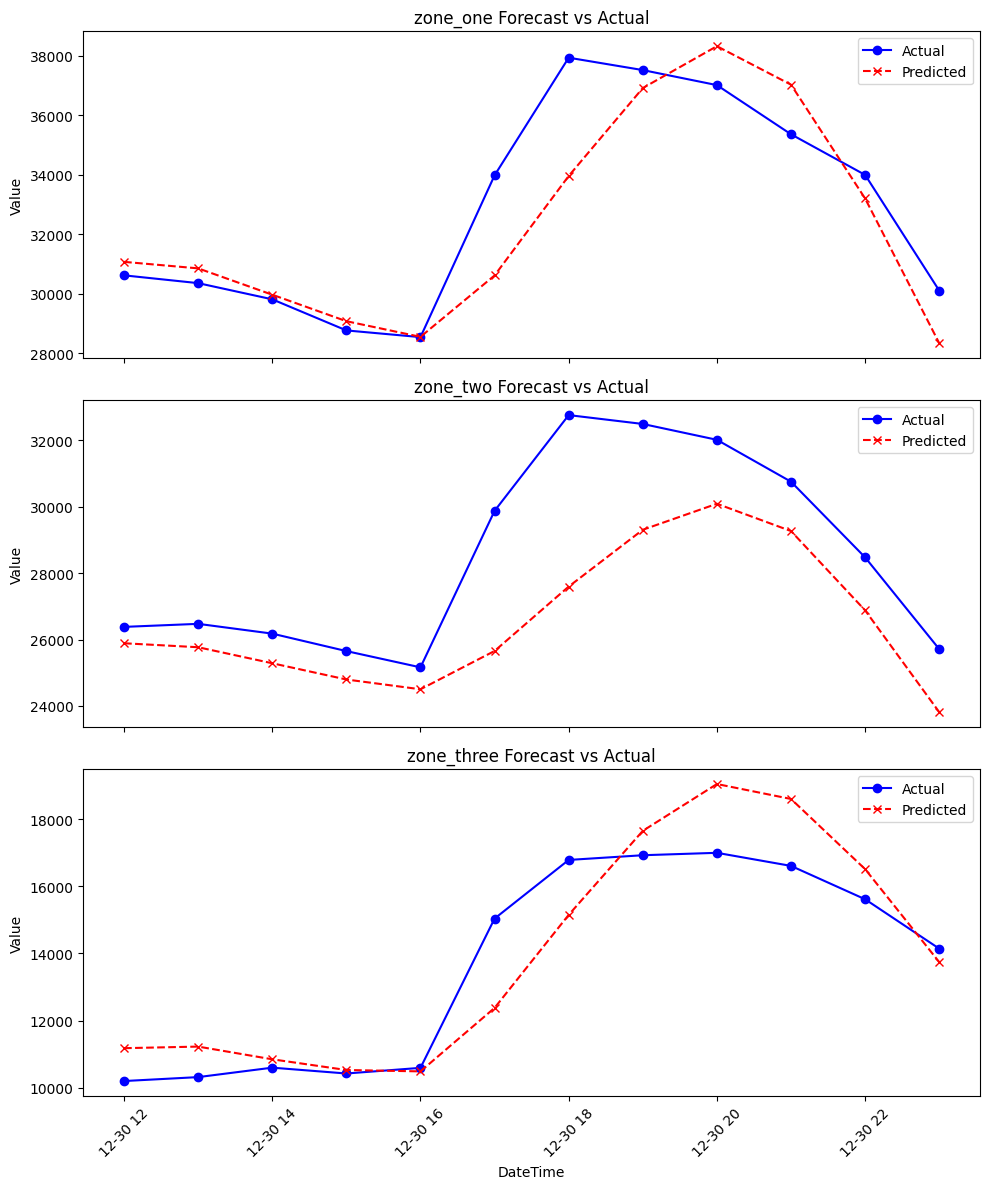

In [ ]:
# Visualization for each zone 
# Compering the actual and predicted values for each zone
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
zones = ['zone_one', 'zone_two', 'zone_three']

for i, zone in enumerate(zones):
    actual = test[zone]
    predicted = forecasts[zone]['yhat']
    dates = test['ds']
    axes[i].plot(dates, actual, label='Actual', color='blue', marker='o')
    axes[i].plot(dates, predicted, label='Predicted', color='red', linestyle='--', marker='x')
    axes[i].set_title(f'{zone} Forecast vs Actual')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)

axes[2].set_xlabel('DateTime')
plt.tight_layout()
plt.show()

# For visualization each zone separately, I used Grok.